In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML


# import vehicle pictures
# downloaded from udacity

notcars=glob.glob('non-vehicles/**/*.png')
cars   =glob.glob(    'vehicles/**/*.png')

image = mpimg.imread(cars[0])
print("Image values max:", np.max(image), ", min:", np.min(image), ", dtype:", image.dtype)
image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
print("after conversion: max:", np.max(image), ", min:", np.min(image), ", dtype:", image.dtype)
print(' ')

#shuffle for better learning?!
np.random.shuffle(cars)
np.random.shuffle(notcars)


def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])



# Plot some random examples
fig, axs = plt.subplots(4,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(0,8):
    img = mpimg.imread(cars[np.random.randint(0,len(cars))]) #RGB
    axs[i].axis('off')
    axs[i].set_title('car')
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = mpimg.imread(notcars[np.random.randint(0,len(notcars))]) #RGB
    axs[i].axis('off')
    axs[i].set_title('notcar')
    axs[i].imshow(img)


Image values max: 0.752941 , min: 0.129412 , dtype: float32
after conversion: max: 0.743443 , min: 0.142541 , dtype: float32
 
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


In [2]:
## Copy of udacity classroom functions
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with tconvert_colorwo outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a fcolor_histunction to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB',color_space_HOG='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if color_space_HOG != 'RGB':
                if color_space_HOG == 'HSV':
                    HOG_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif color_space_HOG == 'LUV':
                    HOG_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif color_space_HOG == 'HLS':
                    HOG_image_HOG = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif color_space_HOG == 'YUV':
                    HOG_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space_HOG == 'YCrCb':
                    HOG_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: HOG_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(HOG_image.shape[2]):
                    hog_features.append(get_hog_features(HOG_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(HOG_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    


In [3]:
print('Start extracting')
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='LUV', color_space_HOG='YCrCb',spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG color spaceCompute HOG features if flag is set
    if hog_feat == True:
        if color_space_HOG != 'RGB':
            if color_space_HOG == 'HSV':
                HOG_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space_HOG == 'LUV':
                HOG_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space_HOG == 'HLS':
                HOG_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space_HOG == 'YUV':
                HOG_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space_HOG == 'YCrCb':
                HOG_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: HOG_image = np.copy(img)      
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(HOG_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(HOG_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    
    #9) Return concatenated array of features
    return np.concatenate(img_features)




### Tweaked according to Vehicle_detection_parameter_exploration.ipynb
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 20    # Number of histogram binscolor_space_HOG = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

color_space_HOG='YCrCb'
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

spatial_feat = True # Spatial features on or off
hist_feat = True#Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [400, 700] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, color_space_HOG=color_space_HOG,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, color_space_HOG=color_space_HOG,
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Start extracting
Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 576


In [4]:

if False:
    print('Start searching2')

    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 20]}
    svr = svm.SVC()
    clf = GridSearchCV(svr, parameters)
    clf.fit(X_train, y_train)

    print("The best parameters are: {}".format(clf.best_params_))




In [5]:
print('Start fitting')

# Use a linear SVC 
svc = svm.SVC(C=5, kernel='rbf')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 5))
# Check the prediction time for a single sample
t=time.time()


Start fitting
19.93 Seconds to train SVC...
Test Accuracy of SVC =  0.99493


In [36]:
class pipeline:
    def __init__(self, vectormachine):
        self.svc=vectormachine
        self.window_list=[]
        self.image_shape=[]
        self.heat =[] 
    def slide_windows(self, shape):
        self.slide_window(shape, x_start_stop=[250,1030], y_start_stop=[400,500], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))  
        self.slide_window(shape, x_start_stop=[None,None], y_start_stop=[400,500], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
        self.slide_window(shape, x_start_stop=[None, None], y_start_stop=[450,600], 
                     xy_window=(128, 128), xy_overlap=(0.6, 0.6))
        print('search_windows: ',len(self.window_list))

    # Define a function you will pass an image 
    # and the list of windows to be searched (output of slide_windows())
    def search_windows(self, img, windows, scaler, color_space='LUV', color_space_HOG='YCrCb',
                        spatial_size=(32, 32), hist_bins=32, 
                        hist_range=(0, 255), orient=9, 
                        pix_per_cell=8, cell_per_block=2, 
                        hog_channel=0, spatial_feat=True, 
                        hist_feat=True, hog_feat=True):
        
        #1) Create an empty list to receive positive detection windows
        on_windows = []
        #2) Iterate over all windows in the list
        for window in windows:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
            #4) Extract features for that window using single_img_features()
            features = single_img_features(test_img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = self.svc.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            
            if prediction == 1:
                on_windows.append(window)
            
        #8) Return windows for positive detections

        return on_windows

    # Define a function that takes an image,
    # start and stop positions in both x and y, 
    # window size (x and y dimensions),  
    # and overlap fraction (for both x and y)
    def slide_window(self, shape, x_start_stop=[None, None], y_start_stop=[None, None], 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]

                # Append window position to list
                self.window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        #print(len(self.window_list))
        #return window_list

    # Define a function to draw bounding boxes
    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
        print('draw_boxes:', len(bboxes))
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy

    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img
    
    def process_frame(self, frame, show=True, boxes = False, show_heat=True):
        # at the first frame or at a different resolution initialize maps
        if frame.shape != self.image_shape:            
            print('Set picture size to', frame.shape)
            self.slide_windows(frame.shape)
            self.image_shape=frame.shape
            #self.heat= np.zeros_like(frame[:,:,0]).astype(np.float)
        # clear hot.windows calculated in previous frame
        hot_windows=[]

        #print('process frame',frame.shape)
        max_channels = np.amax([np.amax(frame[:,:,0]), np.amax(frame[:,:,1]), np.amax(frame[:,:,2])])
        if max_channels > 1:
            print('max_channels:',max_channels)
        draw_frame=np.copy(frame)
        hot_windows = self.search_windows(frame, self.window_list, X_scaler, color_space=color_space, color_space_HOG=color_space_HOG,
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        if boxes:
            return self.draw_boxes(draw_frame, hot_windows, color=(0, 0, 255), thick=6)                    
        # create empty single channel to draw heat on
        heat= np.zeros_like(frame[:,:,0]).astype(np.float)
        # every box adds +1 heat to corresponding pixels
        heat = self.add_heat(heat, hot_windows)
        # remove everything below or at threshold and add it to the list
        self.heat.append(self.apply_threshold(heat,1))
        if len(self.heat)>20:
            self.heat.pop(0)
        heat=np.array(np.sum(self.heat, axis=0))
        # points need to be in at least three consecutive frames
        heat=self.apply_threshold(heat,len(self.heat)/2)
        # use label to find common heatspots
        labels = label(heat)
        # write how many cars are found into the draw_frame
        text='{:d} cars found'.format(labels[1])
        cv2.putText(draw_frame, text, (500, 50), 0, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
        # draw fused boxes 
        draw_img = self.draw_labeled_bboxes(draw_frame, labels)
        
        if show:
            plt.figure()
            plt.imshow(self.draw_boxes(draw_frame, hot_windows, color=(0, 0, 255), thick=6)   )
        if show_heat:
            plt.figure()
            blanc = np.zeros_like(image[:,:,0]).astype(np.float)
            gray = cv2.cvtColor(draw_frame, cv2.COLOR_BGR2GRAY)
            return np.dstack((heat, gray, blanc))
        
        return draw_img
    
    #convert images to the range 0:1 and then call prosess_frame with the right set of parameters. 
    #finally, blow up values to 0:255 in order to send them back into the video. 
    def process_video(self, frame):
        #scale to fit into the process
        frame = frame.astype(np.float32)/255
        #scale back to be displayed correctly
        return self.process_frame(frame, False, False, False )*255


Set picture size to (720, 1280, 3)
search_windows:  94


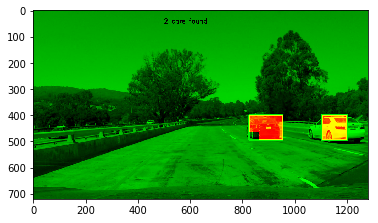

In [37]:
x=pipeline(svc)

test_images=glob.glob("test_images/test*.png")
image=mpimg.imread(test_images[0])
spotted = x.process_frame(image, False, False, True)
plt.figure()
plt.imshow(spotted)



Set picture size to (720, 1280, 3)
search_windows:  94
draw_boxes: 9
Set picture size to (720, 1280, 3)
search_windows:  94
draw_boxes: 0
Set picture size to (720, 1280, 3)
search_windows:  94
draw_boxes: 2
Set picture size to (720, 1280, 3)
search_windows:  94
draw_boxes: 10
Set picture size to (720, 1280, 3)
search_windows:  94
draw_boxes: 7
Set picture size to (720, 1280, 3)
search_windows:  94
draw_boxes: 8
Set picture size to (720, 1280, 3)
search_windows:  94
draw_boxes: 3
Set picture size to (720, 1280, 3)
search_windows:  94
draw_boxes: 3
Set picture size to (720, 1280, 3)
search_windows:  94
draw_boxes: 0
Set picture size to (720, 1280, 3)
search_windows:  94
draw_boxes: 3


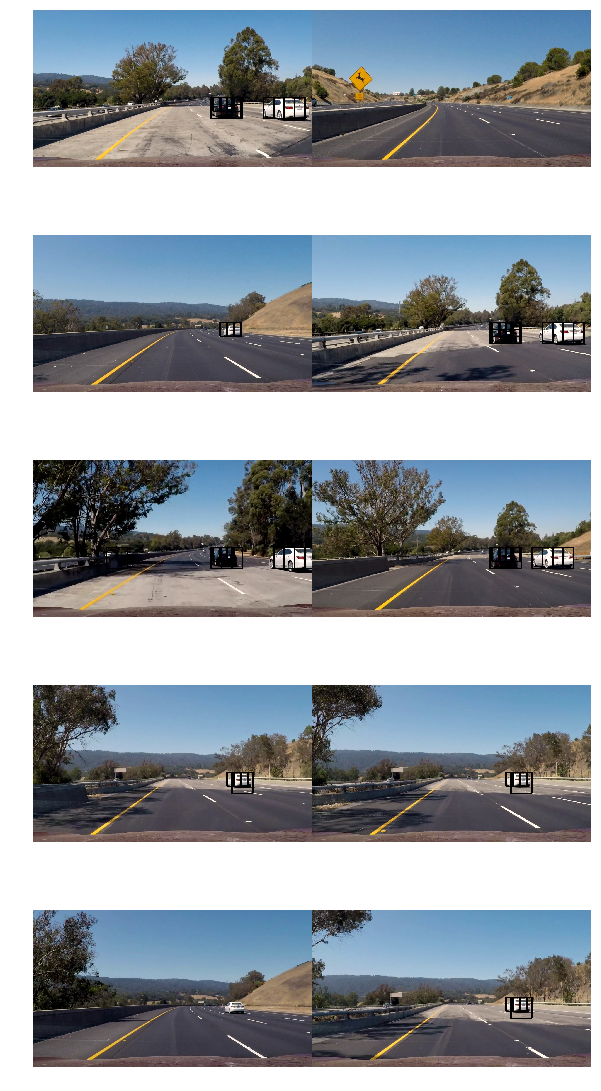

In [38]:
test_images=glob.glob("test_images/*.png")
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

fig15, axs = plt.subplots(5,2, figsize=(10,20))
fig15.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the test images and print 
for idx, fname in enumerate(test_images):
    #reinitialize pipeline in order to clear cached previous lines of the video function
    #image = test_images[idx]
    #for plotting purposes produce a gray and distorted picture
    x=pipeline(svc)
    image=mpimg.imread(fname)
    spotted = x.process_frame(image,False, True, False)
    axs[idx].imshow(spotted)
    axs[idx].axis('off')
fig15.savefig("output_images/pipeline_results.jpg")


In [39]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#the video gets it's own pipeline just to be sure there's nothing cached in there. 
x=pipeline(svc)

output = 'output_videos/test_video.mp4'
clip1 = VideoFileClip("videos/test_video.mp4")
video_clip = clip1.fl_image(x.process_video) 

%time video_clip.write_videofile(output, audio=False)
video_clip.reader.close()
video_clip.audio.reader.close_proc()

Set picture size to (720, 1280, 3)
search_windows:  94
[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4



 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:16<00:00,  2.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

Wall time: 16.9 s


In [40]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#the video gets it's own pipeline just to be sure there's nothing cached in there. 
x=pipeline(svc)

output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("videos/project_video.mp4")#.subclip(20,30)
video_clip = clip1.fl_image(x.process_video) 

%time video_clip.write_videofile(output, audio=False)
video_clip.reader.close()
video_clip.audio.reader.close_proc()

Set picture size to (720, 1280, 3)
search_windows:  94
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4



  5%|████▎                                                                           | 67/1261 [00:28<08:43,  2.28it/s]


 11%|████████▍                                                                      | 135/1261 [00:59<08:37,  2.18it/s]


 16%|████████████▋                                                                  | 203/1261 [01:30<08:01,  2.20it/s]


 21%|████████████████▉                                                              | 271/1261 [02:02<08:46,  1.88it/s]


 27%|█████████████████████▏                                                         | 339/1261 [02:35<07:46,  1.98it/s]


 32%|█████████████████████████▍                                                     | 407/1261 [03:09<07:30,  1.89it/s]


 38%|█████████████████████████████▊                                                 | 475/1261 [03:41<06:17,  2.08it/s]


 43%|██████████████████████████████████                                             | 543/1261 [04:14<05:41,  2.10it/s]


 48%|██████████████████████████████████████▎                                        | 611/1261 [04:47<06:10,  1.76it/s]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [05:21<04:53,  1.99it/s]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [05:54<04:05,  2.10it/s]


 65%|███████████████████████████████████████████████████                            | 815/1261 [06:26<03:30,  2.12it/s]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [06:59<03:01,  2.09it/s]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [07:31<02:27,  2.10it/s]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [08:05<02:05,  1.93it/s]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [08:39<01:22,  2.11it/s]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [09:13<00:53,  1.97it/s]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [09:46<00:18,  2.06it/s]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:04<00:00,  2.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 10min 5s
